In [1]:
# https://codereview.stackexchange.com/questions/219396/cubic-spline-interpolation-in-python-from-scratch
# https://en.wikipedia.org/wiki/Spline_interpolation

import numpy as np
from bisect import bisect_left

class CubicSplineStruct:
    """
    >>> cubicSplineStruct = CubicSplineStruct()
    >>> cubicSplineStruct.m_n = 3
    >>> cubicSplineStruct.m_xvalues =  [0., 10., 42.]
    >>> cubicSplineStruct.computeYtoKMatrix()
    >>> cubicSplineStruct.m_yvalues =   [100., 75., 95.]
    >>> cubicSplineStruct.computeKCoeffs()
    >>> y = cubicSplineStruct.interpolate(30.)
    """
    def __init__(self):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> print(cubicSplineStruct.m_n)
        0
        >>> print(cubicSplineStruct.m_xvalues)
        []
        >>> print(cubicSplineStruct.m_yvalues)
        []
        >>> print(cubicSplineStruct.m_kMatrix)
        []
        >>> print(cubicSplineStruct.m_yMatrix)
        []
        >>> print(cubicSplineStruct.m_ytoKMatrix)
        []
        >>> print(cubicSplineStruct.m_kCoeffs)
        []
        """
        self.m_n = 0
        self.m_xvalues = []
        self.m_yvalues = []
        self.m_kMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_yMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_ytoKMatrix = np.matrix(np.zeros(shape=(0,0)))
        self.m_kCoeffs = []
        pass

    def pushFirstEquationToKMatrix(self, x0, x1):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_kMatrix = np.matrix(np.zeros(shape=(1,5)))
        >>> cubicSplineStruct.pushFirstEquationToKMatrix(1.0, 1.5)
        >>> print(cubicSplineStruct.m_kMatrix[0, 0]) # 2./(x1 - x0)
        4.0
        >>> print(cubicSplineStruct.m_kMatrix[0, 1]) # 1./(x1 - x0)
        2.0
        """
        self.m_kMatrix[0, 0] = 2./(x1 - x0)
        self.m_kMatrix[0, 1] = 1./(x1 - x0)

    def pushLastEquationToKMatrix(self, xnm1, xn):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_kMatrix = np.matrix(np.zeros(shape=(5,5)))
        >>> cubicSplineStruct.pushLastEquationToKMatrix(1.0, 1.5)
        >>> print(cubicSplineStruct.m_kMatrix[-1, -1]) # 2./(xn - xnm1)
        4.0
        >>> print(cubicSplineStruct.m_kMatrix[-1, -2]) # 1./(xn - xnm1)
        2.0
        """
        self.m_kMatrix[-1, -1] = 2./(xn - xnm1)
        self.m_kMatrix[-1, -2] = 1./(xn - xnm1)

    def pushMiddleEquationToKMatrix(self, i, xim1, xi, xip1):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_kMatrix = np.matrix(np.zeros(shape=(4,5)))
        >>> cubicSplineStruct.pushMiddleEquationToKMatrix(3, 1.0, 1.5, 1.75)
        >>> print(cubicSplineStruct.m_kMatrix[3, 2]) # 1./(xi - xim1)
        2.0
        >>> print(cubicSplineStruct.m_kMatrix[3, 3]) # 2./(xi - xim1) + 2./(xip1 - xi)
        12.0
        >>> print(cubicSplineStruct.m_kMatrix[3, 4]) # 1./(xip1 - xi)
        4.0
        """
        self.m_kMatrix[i, i-1] = 1./(xi - xim1)
        self.m_kMatrix[i, i] = 2./(xi - xim1) + 2./(xip1 - xi)
        self.m_kMatrix[i, i + 1] = 1./(xip1 - xi)

    def computeKMatrix(self):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_n = 4
        >>> cubicSplineStruct.m_xvalues = [1.0, 1.5, 1.75, 2.25]
        >>> cubicSplineStruct.computeKMatrix()
        >>> print(cubicSplineStruct.m_kMatrix)
        [[ 4.  2.  0.  0.]
         [ 2. 12.  4.  0.]
         [ 0.  4. 12.  2.]
         [ 0.  0.  2.  4.]]
        """
        self.m_kMatrix = np.matrix(np.zeros(shape=(self.m_n, self.m_n)))
        self.pushFirstEquationToKMatrix(self.m_xvalues[0], self.m_xvalues[1])
        for i in range(1, self.m_n-1):
            self.pushMiddleEquationToKMatrix(i, self.m_xvalues[i-1], self.m_xvalues[i], self.m_xvalues[i+1])
        self.pushLastEquationToKMatrix(self.m_xvalues[-2], self.m_xvalues[-1])

    def pushFirstEquationToYMatrix(self, x0, x1):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_yMatrix = np.matrix(np.zeros(shape=(1,5)))
        >>> cubicSplineStruct.pushFirstEquationToYMatrix(1.0, 1.5)
        >>> print(cubicSplineStruct.m_yMatrix[0, 0]) # -3./(x1 - x0)**2
        -12.0
        >>> print(cubicSplineStruct.m_yMatrix[0, 1]) # 3./(x1 - x0)**2
        12.0
        """
        self.m_yMatrix[0, 0] = -3./(x1 - x0)**2
        self.m_yMatrix[0, 1] = 3./(x1 - x0)**2

    def pushLastEquationToYMatrix(self, xnm1, xn):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_yMatrix = np.matrix(np.zeros(shape=(5,5)))
        >>> cubicSplineStruct.pushLastEquationToYMatrix(1.0, 1.5)
        >>> print(cubicSplineStruct.m_yMatrix[-1, -1]) # 3./(xn - xnm1)**2
        12.0
        >>> print(cubicSplineStruct.m_yMatrix[-1, -2]) # -3./(xn - xnm1)**2
        -12.0
        """
        self.m_yMatrix[-1, -1] = 3./(xn - xnm1)**2
        self.m_yMatrix[-1, -2] = -3./(xn - xnm1)**2


    def pushMiddleEquationToYMatrix(self, i, xim1, xi, xip1):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_yMatrix = np.matrix(np.zeros(shape=(4,5)))
        >>> cubicSplineStruct.pushMiddleEquationToYMatrix(3, 1.0, 1.5, 1.75)
        >>> print(cubicSplineStruct.m_yMatrix[3, 2]) # -3./(xi - xim1)**2
        -12.0
        >>> print(cubicSplineStruct.m_yMatrix[3, 3]) # 3./(xi - xim1)**2 - 3./(xip1 - xi)**2
        -36.0
        >>> print(cubicSplineStruct.m_yMatrix[3, 4]) # 3./(xip1 - xi)**2
        48.0
        """
        self.m_yMatrix[i, i-1] = -3./(xi - xim1)**2
        self.m_yMatrix[i, i] = 3./(xi - xim1)**2 - 3./(xip1 - xi)**2
        self.m_yMatrix[i, i + 1] = 3./(xip1 - xi)**2

    def computeYMatrix(self):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_n = 4
        >>> cubicSplineStruct.m_xvalues = [1.0, 1.5, 1.75, 2.25]
        >>> cubicSplineStruct.computeYMatrix()
        >>> print(cubicSplineStruct.m_yMatrix)
        [[-12.  12.   0.   0.]
         [-12. -36.  48.   0.]
         [  0. -48.  36.  12.]
         [  0.   0. -12.  12.]]
        """
        self.m_yMatrix = np.matrix(np.zeros(shape=(self.m_n, self.m_n)))
        self.pushFirstEquationToYMatrix(self.m_xvalues[0], self.m_xvalues[1])
        for i in range(1, self.m_n-1):
            self.pushMiddleEquationToYMatrix(i, self.m_xvalues[i-1], self.m_xvalues[i], self.m_xvalues[i+1])
        self.pushLastEquationToYMatrix(self.m_xvalues[-2], self.m_xvalues[-1])

    def computeYtoKMatrix(self):
        """
        Should be called when x knot values are updated

        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_n = 4
        >>> cubicSplineStruct.m_xvalues = [0.0, 10./3., 20./3., 10.]
        >>> cubicSplineStruct.computeYtoKMatrix()
        >>> print(cubicSplineStruct.m_ytoKMatrix)
        [[-0.38  0.48 -0.12  0.02]
         [-0.14 -0.06  0.24 -0.04]
         [ 0.04 -0.24  0.06  0.14]
         [-0.02  0.12 -0.48  0.38]]
        """
        self.computeKMatrix()
        self.computeYMatrix()
        self.m_ytoKMatrix = self.m_kMatrix.I*self.m_yMatrix

    def computeKCoeffs(self):
        """
        Should be called when y knot values are updated

        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_n = 2
        >>> cubicSplineStruct.m_ytoKMatrix = np.mat('1 2; 4 5')
        >>> cubicSplineStruct.m_yvalues =[3., 4.]
        >>> cubicSplineStruct.computeKCoeffs()
        >>> print(cubicSplineStruct.m_kCoeffs)
        [11.0, 32.0]
        """   
        kCoeffs = np.array(self.m_yvalues)*self.m_ytoKMatrix.T
        self.m_kCoeffs = [kCoeffs[0, i] for i in range(self.m_n)]

    def interpolateOnInterval(self, intervalIndex, x):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_xvalues = [None, 10., 42.]
        >>> cubicSplineStruct.m_yvalues = [None, 128., -64.]
        >>> cubicSplineStruct.m_kCoeffs = [None, 2., 6.]
        >>> print(cubicSplineStruct.interpolateOnInterval(1, 10.))
        128.0
        >>> print(cubicSplineStruct.interpolateOnInterval(1, 18.))
        98.0
        >>> print(cubicSplineStruct.interpolateOnInterval(1, 34.))
        -58.0
        >>> print(cubicSplineStruct.interpolateOnInterval(1, 42.))
        -64.0
        """ 
        x1 = self.m_xvalues[intervalIndex]
        x2 = self.m_xvalues[intervalIndex+1]
        y1 = self.m_yvalues[intervalIndex]
        y2 = self.m_yvalues[intervalIndex+1]
        t = (x - x1)/(x2 - x1)
        a = computeACoeff(x1, x2, y1, y2, self.m_kCoeffs[intervalIndex])
        b = computeBCoeff(x1, x2, y1, y2, self.m_kCoeffs[intervalIndex+1])
        return (1-t)*y1 + t*y2 + t*(1-t)*(a*(1-t)+b*t)

    def interpolate(self, x):
        """
        >>> cubicSplineStruct = CubicSplineStruct()
        >>> cubicSplineStruct.m_xvalues = [None, 10., 42.]
        >>> cubicSplineStruct.m_yvalues = [None, 128., -64.]
        >>> cubicSplineStruct.m_kCoeffs = [None, 2., 6.]
        >>> cubicSplineStruct.interpolate(18.)
        98.0
        """
        if len(self.m_xvalues) == 0:
            return 0.

        intervalLowerBound = findLowerBound(self.m_xvalues, x)
        return self.interpolateOnInterval(intervalLowerBound, x)

def computeACoeff(x1, x2, y1, y2, k):
    """
    >>> print(computeACoeff( 10., 42., 128., -64., 2.))
    256.0
    """
    return k*(x2 - x1) - (y2 -y1)

def computeBCoeff(x1, x2, y1, y2, k):
    """
    >>> print(computeBCoeff(10., 42., 128., -64., 6.))
    -384.0
    """
    return -k*(x2 - x1) + (y2 -y1)

def findLowerBound(xvalues, x):
    """
    >>> findLowerBound([10., 30.], 9.)
    -1
    >>> findLowerBound([10., 30.], 10.)
    0
    >>> findLowerBound([10., 30.], 15.)
    0
    >>> findLowerBound([10., 30.], 30.)
    0
    >>> findLowerBound([10., 30.], 31.)
    1
    >>> findLowerBound([10., 30., 40.], 9.)
    -1
    >>> findLowerBound([10., 30., 40.], 10.)
    0
    >>> findLowerBound([10., 30., 40.], 15.)
    0
    >>> findLowerBound([10., 30., 40.], 30.)
    0
    >>> findLowerBound([10., 30., 40.], 40.)
    1
    >>> findLowerBound([10., 30., 40.], 41.)
    2
    """
    if xvalues[-1] == x:
        return len(xvalues) - 2

    left = bisect_left(xvalues, x)

    if left >= len(xvalues):
        return len(xvalues) - 1

    if (xvalues[left]==x):
        return 0 if left == 0 else left - 1

    return left - 1

In [2]:
cubicSplineStruct = CubicSplineStruct()
cubicSplineStruct.m_n = 4
cubicSplineStruct.m_xvalues =  [0.0, 10./3., 20./3., 10.]
cubicSplineStruct.computeYtoKMatrix()
cubicSplineStruct.m_yvalues = [128., -64., 128., -64.]
cubicSplineStruct.computeKCoeffs()
print(cubicSplineStruct.interpolate(10./3.)) # -64.0
print(cubicSplineStruct.interpolate(5.)) # 32.0
print(cubicSplineStruct.interpolate(20./3.)) # 128.0


-64.0
32.0
128.0


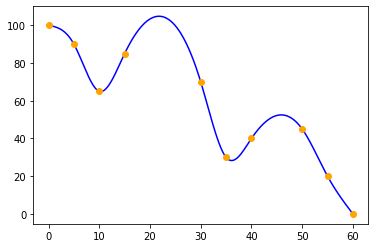

In [3]:
import matplotlib.pyplot as plt

x_values = [0,5,10,15,30,35,40,50,55,60]
y_values = [100,90,65,85,70,30,40,45,20,0]

cubicSplineStruct = CubicSplineStruct()
cubicSplineStruct.m_n = len(x_values)
cubicSplineStruct.m_xvalues =  x_values
cubicSplineStruct.computeYtoKMatrix()
cubicSplineStruct.m_yvalues = y_values
cubicSplineStruct.computeKCoeffs()

new_x_values = [x * 0.1 for x in range(0, 600)]
new_y_values = [cubicSplineStruct.interpolate(x) for x in new_x_values]

plt.plot(new_x_values, new_y_values, '-b')
plt.plot(x_values, y_values, 'o', color='orange')
plt.show()